# Global Forest Change

### Overview 
Global Forest Change is a dataset focused on forest cover change, loss, and gain using Landsat Data.

**Source:** <u>https://storage.googleapis.com/earthenginepartners-hansen/GFC-2024-v1.12/download.html</u>

**Notebook Author:** Cassie Buhler

### Files
To avoid downloading large files directly to our computers, we can stream the data using the files' URLs. There are the 6 files for the granule (top-left corner at 50N, 110W) that includes the Black Hills region. 

 **Tree canopy cover for year 2000** (`treecover2000`):
- Tree cover in the year 2000, defined as canopy closure for all vegetation taller than 5m in height. Encoded as a percentage per output grid cell, in the range 0-100.

**Global forest cover gain 2000-2012** (`gain`):
- Forest gain during the period 2000-2012, defined as the inverse of loss, or a non-forest to forest change entirely within the study period. Encoded as either 1 (gain) or 0 (no gain).
      
**Year of gross forest cover loss event** (`lossyear`):
- Forest loss during the period 2000-2024, defined as a stand-replacement disturbance, or a change from a forest to non-forest state. Encoded as either 0 (no loss) or else a value in the range 1-20, representing loss detected primarily in the year 2001-2024, respectively.

**Data mask** (`datamask`): 
- Three values representing areas of no data (0), mapped land surface (1), and persistent water bodies (2) based on 2000-2012.
  
**Circa year 2000 Landsat 7 cloud-free image composite** (`first`):
- Reference multispectral imagery from the first available year, typically 2000. If no cloud-free observations were available for year 2000, imagery was taken from the closest year with cloud-free data, within the range 1999-2012.

**Circa year 2024 Landsat cloud-free image composite** (`last`): 
- Reference multispectral imagery from the last available year, typically 2024. If no cloud-free observations were available for year 2024, imagery was taken from the closest year with cloud-free data.

In [1]:
#data urls
treecover2000_url = 'https://storage.googleapis.com/earthenginepartners-hansen/GFC-2024-v1.12/Hansen_GFC-2024-v1.12_treecover2000_50N_110W.tif'
gain_url = 'https://storage.googleapis.com/earthenginepartners-hansen/GFC-2024-v1.12/Hansen_GFC-2024-v1.12_gain_50N_110W.tif'
lossyear_url = 'https://storage.googleapis.com/earthenginepartners-hansen/GFC-2024-v1.12/Hansen_GFC-2024-v1.12_lossyear_50N_110W.tif'
datamask_url = 'https://storage.googleapis.com/earthenginepartners-hansen/GFC-2024-v1.12/Hansen_GFC-2024-v1.12_datamask_50N_110W.tif'
first_url = 'https://storage.googleapis.com/earthenginepartners-hansen/GFC-2024-v1.12/Hansen_GFC-2024-v1.12_first_50N_110W.tif'
last_url = 'https://storage.googleapis.com/earthenginepartners-hansen/GFC-2024-v1.12/Hansen_GFC-2024-v1.12_last_50N_110W.tif'

## Inspect spatial projection and extent
Because the Earth is curved, we can't display its surface on a flat map without using a **projection**. A projection transforms the 3D surface of the Earth into a 2D map, and the **coordination reference system (CRS)** of the data will tell us what projection is being used. 

Additionally, it's always good to check the **spatial extent**, as it tells us the area our data covers. 

In [2]:
import rioxarray as rxr

# read in raster data 
treecover2000 = rxr.open_rasterio(treecover2000_url, masked = True)
gain = rxr.open_rasterio(gain_url, masked = True)
lossyear = rxr.open_rasterio(lossyear_url, masked = True)
datamask = rxr.open_rasterio(datamask_url, masked = True)
first = rxr.open_rasterio(first_url, masked = True)
last = rxr.open_rasterio(last_url, masked = True)

# print out projection and spatial extent
print("The CRS:", treecover2000.rio.crs)
print("Spatial extent:", treecover2000.rio.bounds())

The CRS: EPSG:4326
Spatial extent: (-110.0, 40.00000000000001, -100.0, 50.0)


## Crop and reproject data
In this example, the data is currently in `EPSG:4326`, a coordinate system that represents locations using latitude and longitude in degrees. `EPSG:4326` is useful for global datasets, but the units (degrees) are not consistent in actual distances, particularly at higher latitudes. In our data cube, we will use `EPSG:32613` (which corresponds to UTM Zone 13N), a projection in meters that fully encompasses the **Black Hills**.

In addition, the spatial extent of our data spans from:
- Latitude: 40 degrees to 50 degrees
- Longitude: -110 degrees to 100 degrees

This bounding box covers a portion of Canada, Montana, North Dakota, South Dakota, Wyoming, Colorado, and Nebraska. To focus specifically on the Black Hills, we will crop the data to a smaller bounding box and reproject the data to `EPSG:32613`.

The Black Hills bounding box in UTM 13:
- Top: 4961634.142366057 m (`ymax`)
- Bottom: 4791372.654461951 m (`ymin`)
- Left: 522738.38883301965 m (`xmin`)
- Right: 634142.3594250776 m (`xmax`)



In [3]:
# a function to clip and reproject our data
def crop_and_reproject(data, crs = 'EPSG:32613'):
    # black hills bounding box 
    ymax = 4961634.142366057
    ymin = 4791372.654461951
    xmin = 522738.38883301965
    xmax = 634142.3594250776

    # crop data to Black Hills 
    data = data.rio.clip_box(
        minx=xmin,
        miny=ymin,
        maxx=xmax,
        maxy=ymax,
    crs=crs)

    # reproject data to EPSG:32613 
    data = data.rio.reproject(crs)
    return data 

In [4]:
# run the crop_and_reproject function on our rasters
treecover2000 = crop_and_reproject(treecover2000)
gain = crop_and_reproject(gain)
lossyear = crop_and_reproject(lossyear)
datamask = crop_and_reproject(datamask)
first = crop_and_reproject(first)
last = crop_and_reproject(last)

## Data structure 
All raster files have X, Y, and band values.

- X and Y give the pixel’s location (e.g., 40°N, 110°W).
- A band holds the data value for that location.

A single-band raster might show brightness or elevation. Multi-band rasters store different types of data in each band (e.g. red light, infrared, or temperature) allowing deeper analysis. 

In our example, all the files are single-banded except for `first` and `last`. We can see this by printing out the **shape** of each raster, where shape = (bands, X, Y).

In [5]:
# 1 band, 7047 pixels wide, 4707 pixels tall 
print("treecover2000 shape:", treecover2000.shape) 
print("gain shape:", gain.shape) 
print("lossyear shape:", lossyear.shape) 
print("datamask shape:", datamask.shape)

 # 4 bands, 7047 pixes wide, 4707 pixels tall 
print("first shape:", first.shape)
print("last shape:", last.shape) 

treecover2000 shape: (1, 7047, 4707)
gain shape: (1, 7047, 4707)
lossyear shape: (1, 7047, 4707)
datamask shape: (1, 7047, 4707)
first shape: (4, 7047, 4707)
last shape: (4, 7047, 4707)


## Visualize Data

Now that we processed our data and understand its structure, let's make some visualizations!

In [6]:
# python package used to plot and visualize our data
import matplotlib.pyplot as plt

#### Normalized Difference Vegetation Index (NDVI): 2000 vs 2024

NDVI is used to quantify vegetation greenness and is useful in understanding vegetation density and assessing changes in plant health.

NDVI = (NIR - Red) / (NIR + Red)


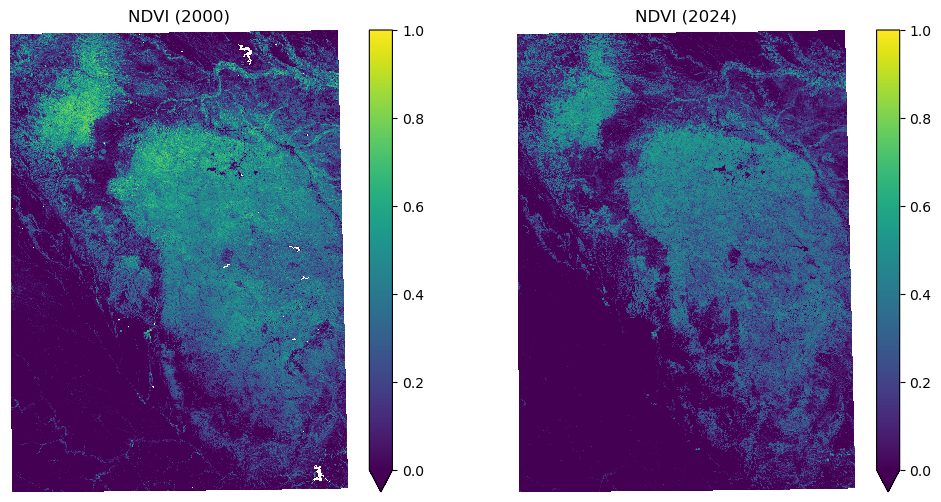

In [7]:
# compute NDVI for first and last
red_first = first.sel(band=1)
nir_first = first.sel(band=2)
ndvi_first = (nir_first - red_first) / (nir_first + red_first)

red_last = last.sel(band=1)
nir_last = last.sel(band=2)
ndvi_last = (nir_last - red_last) / (nir_last + red_last)

# make a figure of size 12x6 with 2 plots, side by side 
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

# turning off x/y labels 
for ax in axs:
    ax.axis('off')

# plotting NDVI for 2000
ndvi_first.plot(ax=axs[0], vmin=0, vmax=1)
axs[0].set_title("NDVI (2000)")

# plotting NDVI for 2024
ndvi_last.plot(ax=axs[1], vmin=0, vmax=1)
axs[1].set_title("NDVI (2024)")

plt.show()  #display the plot 

#### NDVI Change

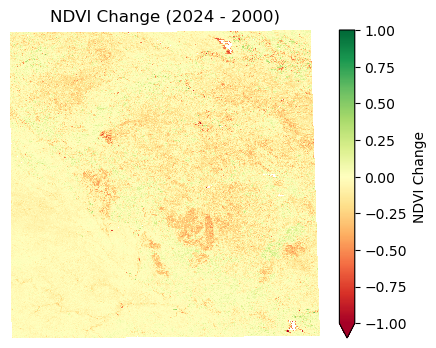

In [8]:
# NDVI change from 2000 to 2024
ndvi_change = ndvi_last - ndvi_first

fig, ax = plt.subplots(figsize=(5, 4))

# plotting the difference 
ndvi_change.plot(ax=ax, cmap="RdYlGn", vmin=-1, vmax=1, cbar_kwargs={'label': 'NDVI Change'})
ax.set_title("NDVI Change (2024 - 2000)")
ax.axis('off') 

plt.show() 

#### Forest Loss Over Time

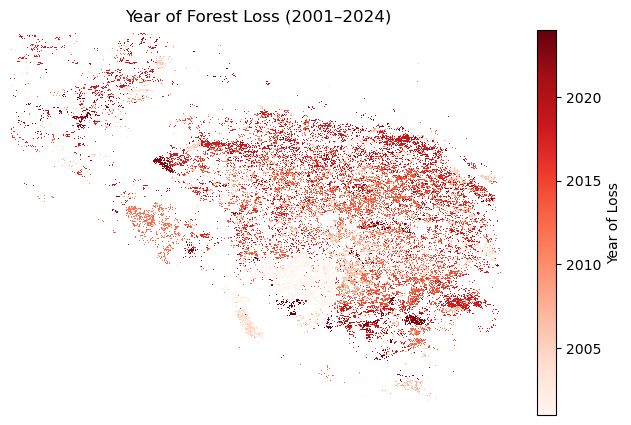

In [9]:
f, ax = plt.subplots(figsize=(8, 5)) 

loss_year = lossyear.sel(band=1) # using only the 1st band
loss_year = loss_year.where(loss_year > 0) # 0 is no loss, otherwise its the year of forest loss 
years = 2000 + loss_year # turning 23 -> 2023. 

# plotting forest loss, darker red -> forest loss is more recent 
im = years.plot(ax=ax, cmap="Reds", cbar_kwargs={'label': 'Year of Loss'})
ax.set_title("Year of Forest Loss (2001–2024)")
ax.axis('off') 

plt.show()

#### Tree Cover Map in 2000


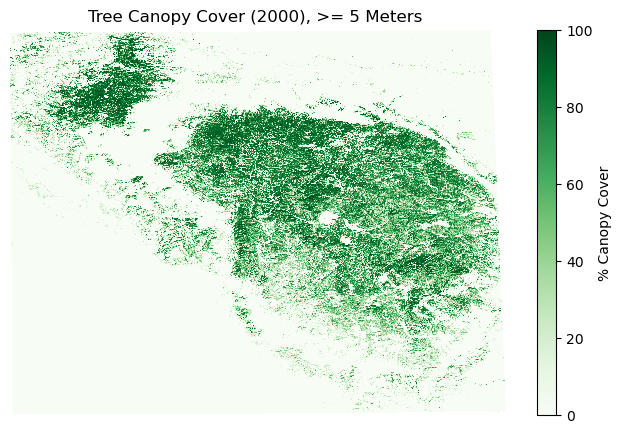

In [10]:
f, ax = plt.subplots(figsize=(8, 5)) 

# plotting tree cover in green
treecover2000.plot(cmap = "Greens",cbar_kwargs={'label': '% Canopy Cover'})
ax.set_title('Tree Canopy Cover (2000), >= 5 Meters ')
ax.axis('off') 

plt.show() 